# Evaluation of Random Forest GEDI -> S1S2 Regression Model

Having successfully ingested GEDI L4A and collocated Sentinel statistical data into a spatiotemporal database, energies now focussed on training a random model regressor to predict wall-to-wall maps of GEDI-estimated Aboveground Biomass Density. Using the functional firepower of PostgreSQL and PostGIS, aggregated subsets of collocated GEDI and Sentinel-based metrics were extracted from the spatiotemporal database as a source of training and test data. 

__Important Note:__ Statistics related to [S2 cloudless mask](https://docs.sentinel-hub.com/api/latest/user-guides/cloud-masks/) were retrieved from Sentinel-Hub and ingested into the Sentinel-2 data tables - records were therefore filtered based on presence of cloud contaimination affecting multispectral statistic calculations.

In [1]:
import pandas as pd
from shapely import wkb

# load dataset
df = pd.read_csv("result.csv" )
df['geometry'] = df['geometry'].apply( wkb.loads, hex=True )

In [2]:
import geopandas as gpd

gdf = gpd.GeoDataFrame( df, geometry='geometry' ) 
gdf.columns

Index(['shot_number', 'datetime', 'ndvi_mean', 'ndvi_stdev', 'evi_mean',
       'evi_stdev', 'gndvi_mean', 'gndvi_stdev', 'ndci_mean', 'ndci_stdev',
       'mcari_mean', 'mcari_stdev', 'lai_mean', 'lai_stdev', 'fapar_mean',
       'fapar_stdev', 'fcover_mean', 'fcover_stdev', 'ccc_mean', 'ccc_stdev',
       'cab_mean', 'cab_stdev', 'vv_mean', 'vv_stdev', 'vh_mean', 'vh_stdev',
       'rvi_mean', 'rvi_stdev', 'agbd', 'agbd_se', 'agbd_t', 'agbd_t_se',
       'solar_elevation', 'landsat_treecover', 'urban_proportion', 'doy',
       'geometry'],
      dtype='object')

60021


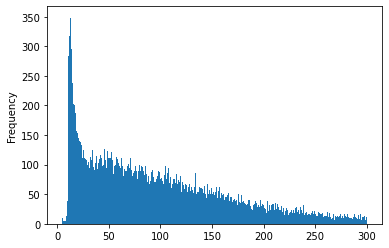

In [3]:
names = [ col for col in gdf.columns if 'stdev' in col or 'mean' in col ]
names.extend( [ 'landsat_treecover', 'agbd' ] )

data = gdf[ names ].copy()
data = data[ ~data.isnull().any(axis=1)]
data = data[ data[ 'landsat_treecover' ] > 70 ]
data = data[ data[ 'agbd'] < 300 ]

data[ 'agbd' ].plot.hist(bins=1000)
print ( len ( data ) )

In [ ]:
corr = data.corr().abs()
data = data [ data.columns[ corr.loc[ 'agbd' ] > 0.12 ] ]

<AxesSubplot:>

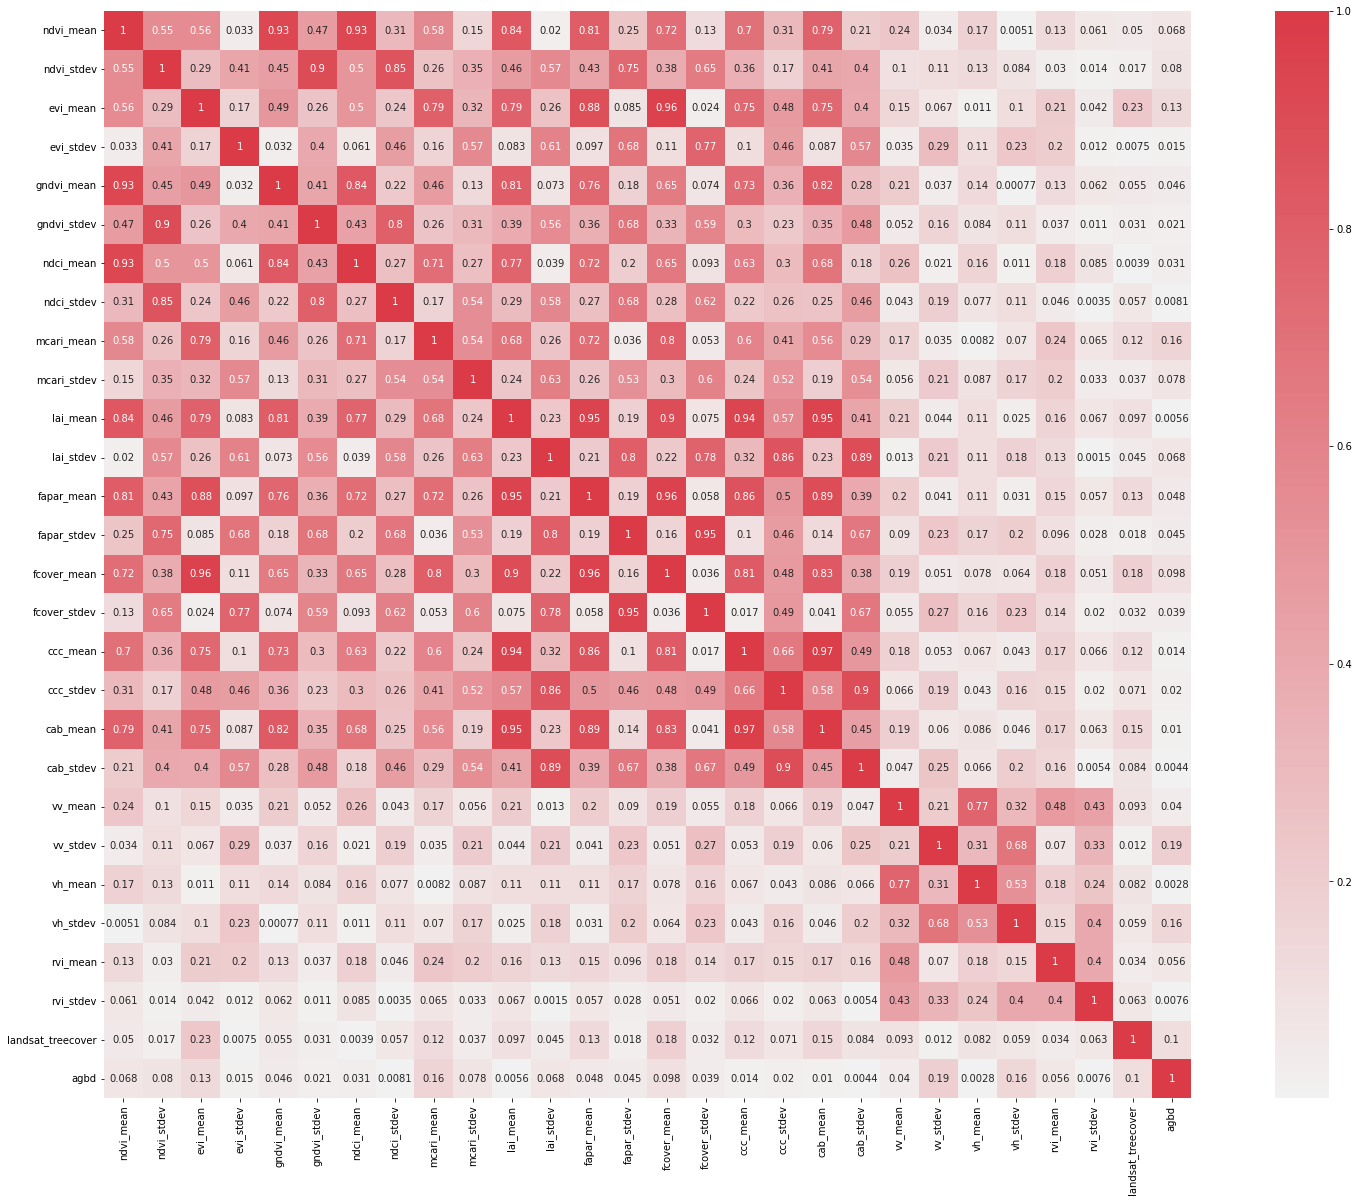

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot correlation matrix
plt.figure( figsize=(30,20) )
cmap = sns.diverging_palette( 500, 10, as_cmap=True )
sns.heatmap( data.corr().abs(), cmap=cmap, center=0, square=True, annot=True )

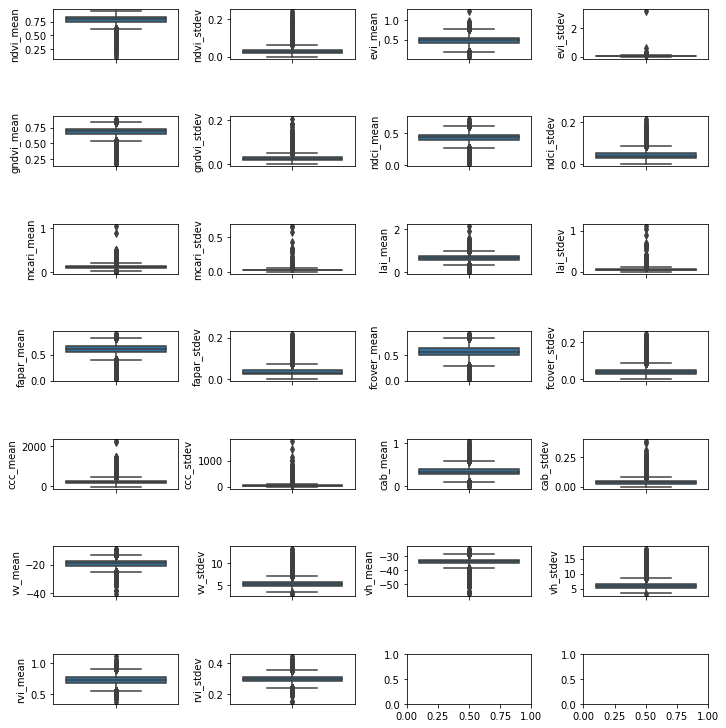

In [5]:
cols = [ col for col in data.columns if 'mean' in col or 'stdev' in col ]

# visualise feature variable distributions using boxplot diagrams
def getBoxPlots( df ):
        
    fig, axs = plt.subplots( ncols=4, nrows=int( len(cols)/4 ) + 1, figsize=(10,10))
    index = 0
    axs= axs.flatten()

    for col in cols:
            sns.boxplot( y=col, data=df, ax=axs[ index ] )
            index += 1

    plt.tight_layout( pad=0.4, w_pad=0.5, h_pad=5.0)
    
getBoxPlots( data )

60021 38687


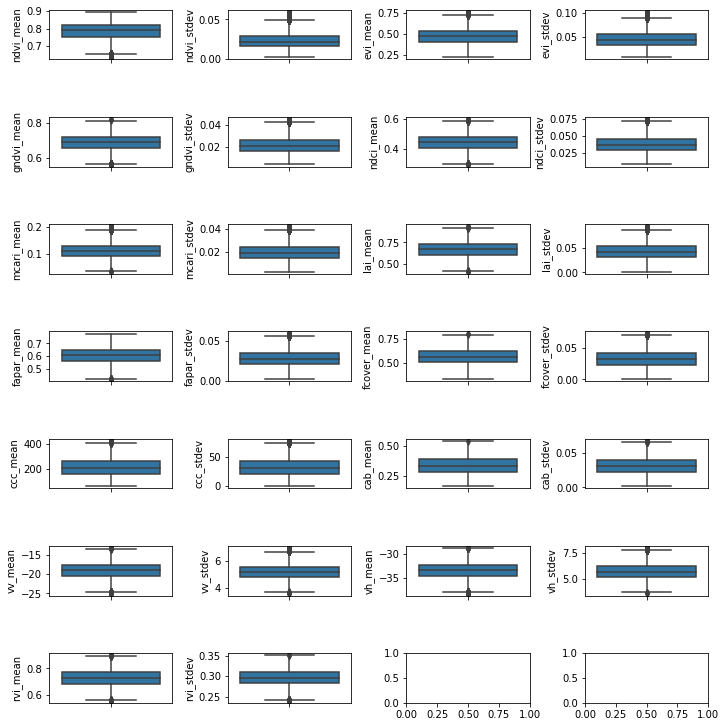

In [6]:
# implement function to filter out rows where predictor variable outside +- IQR * 1.5 ~ 3 stddevs
def filterOutliers( df, column ):

    # compute inter quantile range
    Q1 = df[ column ].quantile(0.25)
    Q3 = df[ column ].quantile(0.75)
    IQR = Q3 - Q1
    
    # filter values between Q1-1.5IQR and Q3+1.5IQR
    return df.query( f'(@Q1 - 1.5 * @IQR) <= {column} <= (@Q3 + 1.5 * @IQR)')

filtered = filterOutliers ( data, 'ndvi_mean' )
for col in cols:
    filtered = filterOutliers ( filtered, col )

getBoxPlots( filtered )
print ( len ( data ), len( filtered ) )

In [7]:
subset = filtered.sample( int( len( filtered ) * 0.95 ) )
len( subset )

36752

<AxesSubplot:>

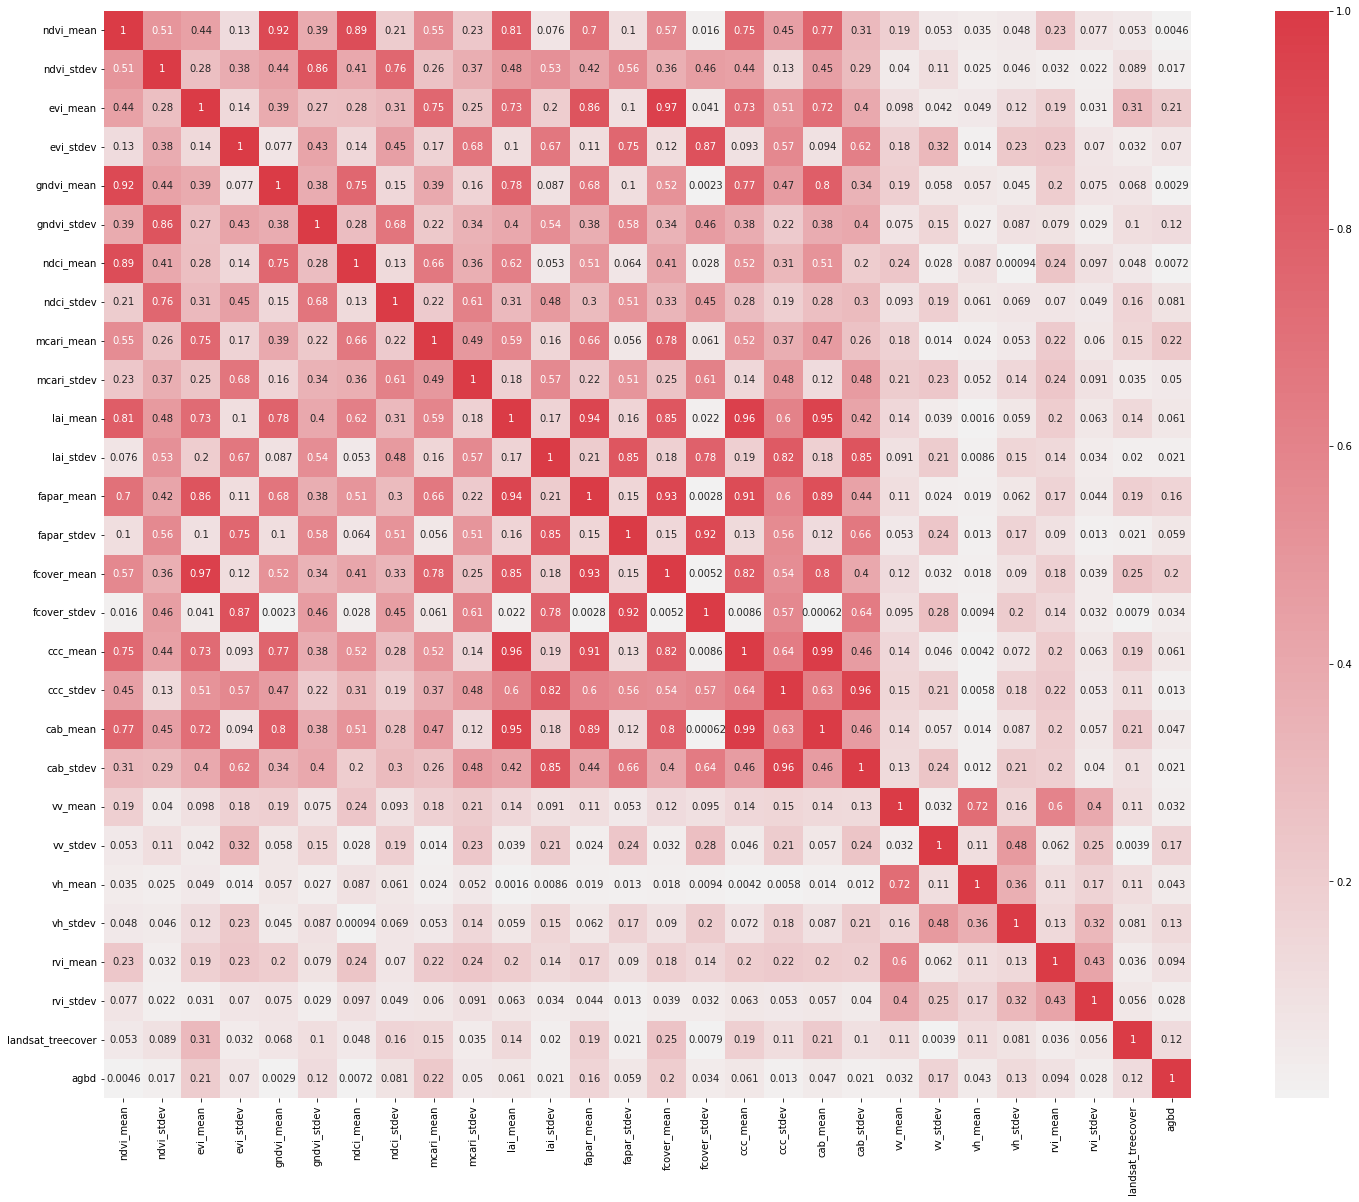

In [8]:
# plot correlation matrix
plt.figure( figsize=(30,20) )
cmap = sns.diverging_palette( 500, 10, as_cmap=True )
sns.heatmap( subset.corr().abs(), cmap=cmap, center=0, square=True, annot=True )

In [9]:
from sklearn.model_selection import train_test_split

target = subset[ 'agbd' ]
features = subset.drop( 'agbd', axis=1 )

X_train, X_test, y_train, y_test = train_test_split( features, target, test_size=0.25 )
X_train.head(5)

,ndvi_mean,ndvi_stdev,evi_mean,evi_stdev,gndvi_mean,gndvi_stdev,ndci_mean,ndci_stdev,mcari_mean,mcari_stdev,...,ccc_stdev,cab_mean,cab_stdev,vv_mean,vv_stdev,vh_mean,vh_stdev,rvi_mean,rvi_stdev,landsat_treecover
67389,0.795556,0.024853,0.401633,0.053579,0.699617,0.022257,0.463926,0.059995,0.104094,0.028069,...,41.040883,0.315528,0.040458,-17.063421,5.009661,-30.005794,5.597505,0.784389,0.287364,97
179306,0.796591,0.036682,0.393073,0.054847,0.710242,0.032661,0.425171,0.058003,0.076059,0.020960,...,42.667386,0.358025,0.042743,-19.754738,6.272142,-36.379679,6.630560,0.624568,0.264663,90
37701,0.667976,0.046314,0.418060,0.044900,0.583232,0.039967,0.336660,0.059832,0.077312,0.022528,...,30.434520,0.265594,0.032216,-22.380207,4.936317,-35.178499,5.716688,0.800142,0.342456,90
239078,0.732685,0.018674,0.391837,0.023027,0.622330,0.019014,0.422230,0.024636,0.109903,0.012789,...,8.966923,0.230824,0.011135,-20.525295,4.824464,-34.387391,5.542131,0.744874,0.285824,90
281619,0.765358,0.018276,0.501216,0.038650,0.660748,0.017989,0.371175,0.022229,0.086797,0.009963,...,69.692045,0.406608,0.055139,-20.163415,5.375135,-32.755436,4.305352,0.804668,0.277816,72


In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

# get estimators
estimators = [ ('standardize', StandardScaler() ), 
               ('mlp', xgb.XGBRegressor( verbosity=1 ) ) ]

pipeline = Pipeline(estimators)

In [11]:
from sklearn.model_selection import GridSearchCV

# grid search space
"""
param_grid = {  'mlp__n_estimators': [400, 700, 1000],
                'mlp__colsample_bytree': [0.7, 0.8],
                'mlp__max_depth': [15,20,25],
                'mlp__reg_alpha': [1.1, 1.2, 1.3],
                'mlp__reg_lambda': [1.1, 1.2, 1.3],
                'mlp__subsample': [0.7, 0.8, 0.9]
}
"""

param_grid = {  'mlp__n_estimators': [ 500 ],
                'mlp__colsample_bytree': [0.8],
                'mlp__max_depth': [ 50 ],
                'mlp__reg_alpha': [1.3],
                'mlp__reg_lambda': [1.3],
                'mlp__subsample': [ 0.8 ]
}


# grid search object
gs = GridSearchCV(
        pipeline,
        param_grid=param_grid, 
        cv=10, 
        scoring='neg_mean_squared_error',
        verbose=1
    )

In [12]:
# compute models ov er parameter grid
best_model = gs.fit(X_train, y_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


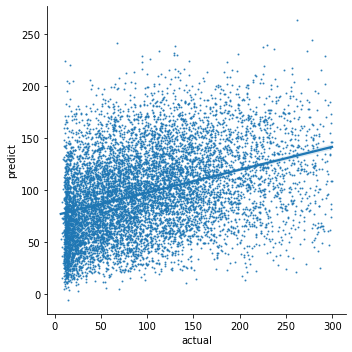

In [13]:
import seaborn as sns

result = pd.DataFrame( { 'actual' :  y_test.values, 'predict' : best_model.predict( X_test ) } )
sns.lmplot(x='actual',y='predict', data=result, fit_reg=True, scatter_kws={"s": 1 } ) 

In [14]:
result[ 'actual' ].corr( result[ 'predict' ] )

0.36275215100838654

In [15]:
print(best_model.best_score_)
print(best_model.best_params_)

-4457.715709462861
{'mlp__colsample_bytree': 0.8, 'mlp__max_depth': 50, 'mlp__n_estimators': 500, 'mlp__reg_alpha': 1.3, 'mlp__reg_lambda': 1.3, 'mlp__subsample': 0.8}


In [16]:
corr = data.corr().abs()
data.columns[ corr.loc[ 'agbd' ] > 0.12 ]

Index(['evi_mean', 'mcari_mean', 'vv_stdev', 'vh_stdev', 'agbd'], dtype='object')